## Name: JR Lee

## Final Assignment Overview: Working with Patient Records and Encounter Notes

In this final assignment, we’ll focus on patient records related to COVID-19 encounters. Our task is to analyze, process, and transform the data while applying the concepts we’ve covered throughout this course. Here's a detailed breakdown of the assignment:

What Are Encounter Notes?
An encounter note is a record that captures details about a patient’s visit with a doctor. It includes both structured and semi-structured information that is crucial for understanding the context of the visit. Here’s what an encounter note typically looks like:

```
AMBULATORY ENCOUNTER NOTE
Date of Service: March 2, 2020 15:45-16:30

DEMOGRAPHICS:
Name: Jeffrey Greenfelder
DOB: 1/16/2005
Gender: Male
Address: 428 Wiza Glen Unit 91, Springfield, Massachusetts 01104
Insurance: Guardian
MRN: 055ae6fc-7e18-4a39-8058-64082ca6d515

PERTINENT MEDICAL HISTORY:
- Obesity 

Recent Visit: Well child visit (2/23/2020)
Immunizations: Influenza vaccine (2/23/2020)

Recent Baseline (2/23/2020):
Height: 155.0 cm
Weight: 81.2 kg
BMI: 33.8 kg/m² (99.1th percentile)
BP: 123/80 mmHg
HR: 92/min
RR: 13/min

SUBJECTIVE:
Adolescent patient presents with multiple symptoms including:
- Cough
- Sore throat
- Severe fatigue
- Muscle pain
- Joint pain
- Fever
Never smoker. Symptoms began recently.

OBJECTIVE:
Vitals:
Temperature: 39.3°C (102.7°F)
Heart Rate: 131.1/min
Blood Pressure: 120/73 mmHg
Respiratory Rate: 27.6/min
O2 Saturation: 75.8% on room air
Weight: 81.2 kg

Laboratory/Testing:
Comprehensive Respiratory Panel:
- Influenza A RNA: Negative
- Influenza B RNA: Negative
- RSV RNA: Negative
- Parainfluenza virus 1,2,3 RNA: Negative
- Rhinovirus RNA: Negative
- Human metapneumovirus RNA: Negative
- Adenovirus DNA: Negative
- SARS-CoV-2 RNA: Positive

ASSESSMENT:
1. Suspected COVID-19 with severe symptoms
2. Severe hypoxemia requiring immediate intervention
3. Tachycardia (HR 131)
4. High-grade fever
5. Risk factors:
   - Obesity (BMI 33.8)
   - Adolescent age

PLAN:
1. Face mask provided for immediate oxygen support
2. Infectious disease care plan initiated
3. Close monitoring required due to:
   - Severe hypoxemia
   - Tachycardia
   - Age and obesity risk factors
4. Parent/patient education on:
   - Home isolation protocols
   - Warning signs requiring emergency care
   - Return precautions
5. Follow-up plan:
   - Daily monitoring during acute phase
   - Virtual check-ins as needed

Encounter Duration: 45 minutes
Encounter Type: Ambulatory
Provider: ID# e2c226c2-3e1e-3d0b-b997-ce9544c10528
Facility: 5103c940-0c08-392f-95cd-446e0cea042a
```


The enocuter contains

* General encounter information: 

  * When the encounter took place: Date and time of the visit.
  * Demographics: Patient’s age, gender, and unique medical record identifier.
  * Encounter details: The reason for the visit, diagnosis, and any associated costs.


* Semi-Structured Notes:

These notes mirror how doctors organize their thoughts and observations during an encounter. They generally follow a SOAP format:

* Subjective: The patient’s subjective description of their symptoms, feelings, and medical concerns.
* Objective: The doctor’s objective findings, including test results, measurements, or physical examination outcomes.
* Assessment: The doctor’s evaluation or diagnosis based on subjective and objective information.
* Plan: The proposed treatment plan, including medications, follow-ups, or other interventions.

While some encounter notes might include additional details, the majority conform to this semi-structured format, making them ideal for analysis and transformation.

* Goals for the Assignment

1. Transforming Encounter Notes:

Using an LLM to convert semi-structured encounter notes into a JSON format that organizes the information into structured fields. The JSON will include details such as demographics, encounter specifics, and the SOAP components of the note. Subsequently, you will need to transform the JSON data into a Parquet file, which is not only suitable for analysis in Spark but also ideal for storage later.
Here we will use the ML classificaition to assing the objective and assessment semi-structured fields into standardized, structured fields. The medical taxonomy for this task will be the one provided by the CDC, which defines standard codes for diagnoses, symptoms, procedures, and treatments. This step ensures the structured data aligns with domain-wide medical standards, making it interoperable and ready for deeper analysis.

The JSON format should capture the hierachies described in the structure below. 

In [1]:
# EncounterType:
#     code
#     description

# Encounter:
#     id
#     date
#     time
#     type: EncounterType
#     provider_id
#     facility_id

# Address:
#     city
#     state

# Demographics:
#     id
#     name
#     date_of_birth
#     age
#     gender
#     address: Address
#     insurance

# Condition:
#     code
#     description

# Medication:
#     code
#     description

# Immunization:
#     code
#     description
#     date: date

# VitalMeasurement:
#     code
#     value: float
#     unit

# BloodPressure:
#     systolic: VitalMeasurement
#     diastolic: VitalMeasurement

# CurrentVitals:
#     temperature: VitalMeasurement
#     heart_rate: VitalMeasurement
#     blood_pressure: BloodPressure
#     respiratory_rate: VitalMeasurement
#     oxygen_saturation: VitalMeasurement
#     weight: VitalMeasurement

# BaselineVitals:
#     date: date
#     height: VitalMeasurement
#     weight: VitalMeasurement
#     bmi: VitalMeasurement
#     bmi_percentile: VitalMeasurement

# Vitals:
#     current: CurrentVitals
#     baseline: BaselineVitals

# RespiratoryTest:
#     code
#     result

# RespiratoryPanel:
#     influenza_a: RespiratoryTest
#     influenza_b: RespiratoryTest
#     rsv: RespiratoryTest
#     parainfluenza_1: RespiratoryTest
#     parainfluenza_2: RespiratoryTest
#     parainfluenza_3: RespiratoryTest
#     rhinovirus: RespiratoryTest
#     metapneumovirus: RespiratoryTest
#     adenovirus: RespiratoryTest

# Covid19Test:
#     code
#     description
#     result

# Laboratory:
#     covid19: Covid19Test
#     respiratory_panel: RespiratoryPanel

# Procedure:
#     code
#     description
#     date: date
#     reasonCode
#     reasonDescription

# CarePlan:
#     id
#     code
#     description
#     start: date
#     stop: date
#     reasonCode
#     reasonDescription

# PatientRecord:
#     encounter: Encounter
#     demographics: Demographics
#     conditions: List[Condition]
#     medications: List[Medication]
#     immunizations: List[Immunization]
#     vitals: Vitals
#     laboratory: Laboratory
#     procedures: List[Procedure]
#     care_plans: List[CarePlan]

In [2]:
import os
import json
from dotenv import load_dotenv
from pydantic import BaseModel, Field, field_validator, model_validator
from typing import List, Optional
from datetime import date, time
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain

To find list of medications and their codes, search by similarity at the embedding level (find top 10 most similar with FAISS)

Retrieval Augmented Generation


In [3]:
class Encounter(BaseModel): 
    code: Optional[int] = Field(None, description="Code representing the encounter type.") 
    encounter_start: date = Field(..., description="Date of the encounter (ISO format).")
    description: str = Field(..., description="Description of the encounter type.")
    provider_id: str = Field(..., description="Unique identifier for the healthcare provider.")
    facility_id: str = Field(..., description="Unique identifier for the facility where the encounter occurred.")

class Address(BaseModel):
    street: Optional[str] = Field(None, description="Street address of the patient's residence.")
    city: str = Field(..., description="City of the patient's residence.")
    state: str = Field(..., description="State of the patient's residence.")
    zip: Optional[str] = Field(None, description="Zip code of the patient's residence.")

class Demographics(BaseModel):
    name: str = Field(..., description="Full name of the patient.")
    date_of_birth: date = Field(..., description="Date of birth of the patient (ISO format).")
    age: int = Field(..., description="Age of the patient in years, to be calculated from subtracting date of birth from date of service.")
    gender: str = Field(..., description="Gender of the patient.")
    insurance: str = Field(..., description="Insurance information for the patient.")

class Symptom(BaseModel):
    description: List[str] = Field(..., description="List of all symptoms (e.g., 'fever', 'cough').")

    @field_validator("description", mode="before")
    def ensure_list(cls, value):
        """Ensures the description is always a list."""
        if isinstance(value, str):
            return [value]  # Convert single string to list
        if isinstance(value, list):
            return value
        raise ValueError("Description must be a list of strings.")

class Medication(BaseModel):
    code: Optional[int] = Field(None, description="Code representing the medication.")
    description: Optional[str] = Field(None, description="Description of the medication (e.g., 'Hydrochlorothiazide 12.5 MG daily').")

class Immunization(BaseModel):
    code: Optional[int] = Field(None, description="Code representing the immunization.")
    description: str = Field(..., description="Description of the immunization (e.g., 'Influenza vaccine').")
    immunization_date: Optional[date] = Field(None, description="Date the immunization was administered (ISO format).")

class VitalMeasurement(BaseModel):
    code: Optional[str] = Field(None, description="Code representing the vital sign (e.g., '8310-5' for Body temperature).")
    value: float = Field(..., description="Value of the measurement.")
    unit: str = Field(..., description="Unit of the measurement (e.g., 'Celsius').")

class BloodPressure(BaseModel):
    systolic: Optional[VitalMeasurement] = Field(None, description="Systolic blood pressure measurement.")
    diastolic: Optional[VitalMeasurement] = Field(None, description="Diastolic blood pressure measurement.")

    @model_validator(mode="before")
    def convert_plain_integers(cls, values):
        """
        Convert integer values to VitalMeasurement instances with default units.
        """
        for key in ['systolic', 'diastolic']:
            if key in values and isinstance(values[key], int):
                values[key] = VitalMeasurement(value=values[key], unit="mmHg")
        return values

class CurrentVitals(BaseModel):
    temperature: VitalMeasurement = Field(..., description="Patient's current temperature.")
    heart_rate: VitalMeasurement = Field(..., description="Patient's current heart rate.")
    blood_pressure: BloodPressure = Field(..., description="Patient's current blood pressure.")
    respiratory_rate: VitalMeasurement = Field(..., description="Patient's current respiratory rate.")
    oxygen_saturation: VitalMeasurement = Field(..., description="Patient's current oxygen saturation level.")
    weight: VitalMeasurement = Field(..., description="Patient's current weight.")

class BaselineVitals(BaseModel):
    vital_measurement_date: Optional[date] = Field(None, description="Date of the baseline measurement (ISO format).")
    height: Optional[VitalMeasurement] = Field(None, description="Patient's height at baseline.")
    weight: Optional[VitalMeasurement] = Field(None, description="Patient's weight at baseline.")
    bmi: Optional[VitalMeasurement] = Field(None, description="Patient's BMI at baseline.")
    bmi_percentile: Optional[VitalMeasurement] = Field(None, description="Patient's BMI percentile at baseline.")

class Vitals(BaseModel):
    current: CurrentVitals = Field(..., description="Current vitals of the patient.")
    baseline: Optional[BaselineVitals] = Field(None, description="Baseline vitals of the patient.")

class RespiratoryTest(BaseModel):
    name: str = Field(..., description="Name of the test.")
    result: str = Field(..., description="Result of the respiratory test (e.g., 'Negative').")

class RespiratoryPanel(BaseModel):
    influenza_a: Optional[RespiratoryTest] = Field(None, description="Result for Influenza A RNA test.")
    influenza_b: Optional[RespiratoryTest] = Field(None, description="Result for Influenza B RNA test.")
    rsv: Optional[RespiratoryTest] = Field(None, description="Result for RSV RNA test.")
    parainfluenza_1: Optional[RespiratoryTest] = Field(None, description="Result for Parainfluenza 1 RNA test.")
    parainfluenza_2: Optional[RespiratoryTest] = Field(None, description="Result for Parainfluenza 2 RNA test.")
    parainfluenza_3: Optional[RespiratoryTest] = Field(None, description="Result for Parainfluenza 3 RNA test.")
    rhinovirus: Optional[RespiratoryTest] = Field(None, description="Result for Rhinovirus RNA test.")
    metapneumovirus: Optional[RespiratoryTest] = Field(None, description="Result for Human Metapneumovirus RNA test.")
    adenovirus: Optional[RespiratoryTest] = Field(None, description="Result for Adenovirus DNA test.")

class Covid19Test(BaseModel):
    code: str = Field(..., description="Code for the COVID-19 test.")
    description: str = Field(..., description="Description of the COVID-19 test.")
    result: str = Field(..., description="Result of the COVID-19 test (e.g., 'Positive').")

class Laboratory(BaseModel):
    covid19: Covid19Test = Field(..., description="COVID-19 test details.")
    respiratory_panel: RespiratoryPanel = Field(..., description="Details of the comprehensive respiratory panel.")

class Procedure(BaseModel):
    code: str = Field(..., description="Code representing the procedure.")
    description: str = Field(..., description="Description of the procedure.")
    procedure_date: date = Field(..., description="Date the procedure was performed.")
    reasonCode: str = Field(..., description="Code for the reason the procedure was performed.")
    reasonDescription: str = Field(..., description="Description of the reason the procedure was performed.")

class CarePlan(BaseModel):
    description: str = Field(..., description="Description of the care plan (e.g., 'Face mask and oxygen support provided').")
    start: Optional[date] = Field(None, description="Start date of the care plan.")
    stop: Optional[date] = Field(None, description="Stop date of the care plan (if applicable).")
    reasonCode: Optional[int] = Field(None, description="Code for the reason the care plan was initiated.")
    reasonDescription: Optional[str] = Field(None, description="Description of the reason the care plan was initiated.")

class PatientRecord(BaseModel):
    id: str = Field(..., description="Medical Record Number for the patient (e.g., '055ae6fc-7e18-4a39-8058-64082ca6d515').")
    encounter: Encounter = Field(..., description="Details of the patient's encounter.")
    symptoms: List[Symptom] = Field(..., description="List of symptoms reported by the patient.")
    demographics: Demographics = Field(..., description="Demographic information of the patient.")
    medications: List[Medication] = Field(..., description="List of medications prescribed to the patient.")
    immunizations: Optional[List[Immunization]] = Field(None, description="List of immunizations received by the patient.")
    vitals: Vitals = Field(..., description="Current and baseline vitals of the patient.")
    laboratory: Laboratory = Field(..., description="Laboratory test results for the patient.")
    procedures: Optional[List[Procedure]] = Field(None, description="List of procedures performed on the patient.")
    care_plans: List[CarePlan] = Field(..., description="List of care plans for the patient.")

    @field_validator("care_plans")
    def validate_care_plans(cls, value):
        """Ensure that care_plans is not empty."""
        if not value:
            raise ValueError("care_plans must contain at least one entry.")
        return value

In [4]:
def extract_query_text(file_path):
    with open(file_path, "r") as f:
        query_text = f.read()
    return query_text

In [5]:
def save_output_to_json(patient_record, output_path, file_name):
    output_file_path = os.path.join(output_path, file_name + ".json")

    # Convert the patient record to JSON
    patient_record_json = patient_record.model_dump_json(indent=4)

    # Write to the file
    with open(output_file_path, "w") as json_file:
        json_file.write(patient_record_json)

In [6]:
def extract_json_from_text(encounter_notes_directory_path):
    try:
        llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0,
            api_key=OPENAI_API_KEY
        )

        structured_llm = llm.with_structured_output(PatientRecord)

        # Ensure the output directory exists
        output_directory = os.path.join(encounter_notes_directory_path, "output")
        os.makedirs(output_directory, exist_ok=True)

        # Process files in the input directory
        for file_name in os.listdir(encounter_notes_directory_path):
            file_path = os.path.join(encounter_notes_directory_path, file_name)

            # Skip if not a file
            if not os.path.isfile(file_path):
                print(f"Skipping {file_path}, not a file.")
                continue

            # Check if the file has already been processed
            output_file_path = os.path.join(output_directory, f"{file_name}.json")
            if os.path.exists(output_file_path):
                print(f"Skipping {file_name}, already processed.")
                continue

            # Process the file
            try:
                print(f"\nProcessing {file_path}")
                query_text = extract_query_text(file_path)
                patient_record = structured_llm.invoke(query_text)
                save_output_to_json(patient_record, output_directory, file_name)  # Pass the correct output directory
                print(f"Successfully processed {file_name}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    except Exception as e:
        print(f"Error initializing ChatOpenAI or processing directory: {e}")


In [7]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
extract_json_from_text("data/encounter_notes")

Skipping ae9efba3-ddc4-43f9-a781-f72019388548.txt, already processed.
Skipping 28658715-b770-4576-9a81-fbb2282a98ea.txt, already processed.
Skipping data/encounter_notes/output (med code added), not a file.
Skipping f0f3bc8d-ef38-49ce-a2bd-dfdda982b271.txt, already processed.
Skipping 199c586f-af16-4091-9998-ee4cfc02ee7a.txt, already processed.
Skipping data/encounter_notes/output, not a file.
Skipping 055ae6fc-7e18-4a39-8058-64082ca6d515.txt, already processed.
Skipping d22592ac-552f-4ecd-a63d-7663d77ce9ba.txt, already processed.
Skipping b9fd2dd8-181b-494b-ab15-e9f286d668d9.txt, already processed.
Skipping f73d6f41-0091-4485-8b43-9d38eb98fb36.txt, already processed.
Skipping 353016ea-a0ff-4154-85bb-1cf8b6cedf20.txt, already processed.
Skipping df6b563d-1ff4-4833-9af8-84431e641e9c.txt, already processed.


### Save to .json file

In [8]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
medication_file_path = "data/medications_assignment_1.csv"
medications_df = pd.read_csv(medication_file_path)
codes = medications_df['CODE'].tolist()
medications = medications_df['DESCRIPTION'].tolist()
model = SentenceTransformer('all-MiniLM-L6-v2')
medication_embeddings = model.encode(medications, convert_to_numpy=True)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Create a FAISS index
dimension = medication_embeddings.shape[1]  # Dimensionality of the embeddings
index = faiss.IndexFlatL2(dimension)
index.add(medication_embeddings)

# Save the index and codes mapping for later use
faiss.write_index(index, "medication_index.faiss")
with open("codes_mapping.txt", "w") as f:
    for code in codes:
        f.write(f"{code}\n")

In [10]:
codes = []
embeddings = []

# Read and encode the medication file
with open("data/medications_assignment_1.csv", "r") as f:
    for i, line in enumerate(f):
        if i > 1: 
            parts = line.strip().split(",")
            codes.append(parts[0])  # Medication code or name
            embeddings.append(model.encode(parts[1]))

# Normalize embeddings
embeds = np.array(embeddings)
faiss.normalize_L2(embeds)

# Create and populate the FAISS index
index = faiss.IndexFlatIP(embeds.shape[1])
index.add(embeds)

# Process patient JSON files and update medications with closest matches
input_dir = "data/encounter_notes/output"
output_dir = "data/encounter_notes/output (med code added)"
os.makedirs(output_dir, exist_ok=True) 

for file_name in os.listdir(input_dir):
    if not file_name.endswith(".json"):
        continue

    file_path = os.path.join(input_dir, file_name)
    with open(file_path, "r") as f:
        patient_data = json.load(f)

    medications = patient_data.get("medications", [])
    for med in medications:
        description = med.get("description")
        if description:
            # Encode and search for the closest match
            embed_med = model.encode(description)
            distances, indices = index.search(np.array([embed_med]), k=1)
            med["code"] = codes[indices[0][0]]

    # Save the updated JSON to the output directory
    output_file_path = os.path.join(output_dir, file_name)
    with open(output_file_path, "w") as f:
        json.dump(patient_data, f, indent=4)

    print(f"Updated file saved to: {output_file_path}")


Updated file saved to: data/encounter_notes/output (med code added)/f73d6f41-0091-4485-8b43-9d38eb98fb36.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/353016ea-a0ff-4154-85bb-1cf8b6cedf20.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/b9fd2dd8-181b-494b-ab15-e9f286d668d9.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/199c586f-af16-4091-9998-ee4cfc02ee7a.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/d22592ac-552f-4ecd-a63d-7663d77ce9ba.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/28658715-b770-4576-9a81-fbb2282a98ea.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/f0f3bc8d-ef38-49ce-a2bd-dfdda982b271.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/ae9efba3-ddc4-43f9-a781-f72019388548.txt.json
Updated file saved to: data/encounter_notes/output (med code added)/df6b563d-1ff4-4833-9

In [11]:
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
import os
from pyspark.sql.functions import when, col, explode, count, rank, avg, lit, expr, hour
from pyspark.sql.functions import sum as _sum
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

In [12]:
schema = StructType([
    StructField("demographics", StructType([
        StructField("address", StructType([
            StructField("city", StringType(), True),
            StructField("state", StringType(), True)
        ]), True),
        StructField("age", LongType(), True),
        StructField("date_of_birth", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("insurance", StringType(), True),
        StructField("name", StringType(), True)
    ]), True),
    StructField("encounter", StructType([
        StructField("date", StringType(), True),
        StructField("facility_id", StringType(), True),
        StructField("provider_id", StringType(), True),
        StructField("time", StringType(), True)
    ]), True),
    StructField("conditions", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("description", StringType(), True)
    ]), True), True),
    StructField("medications", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("description", StringType(), True)
    ]), True), True),
    StructField("immunizations", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("date", StringType(), True),
        StructField("description", StringType(), True)
    ]), True), True),
    StructField("vitals", StructType([
        StructField("baseline", StructType([
            StructField("date", StringType(), True),
            StructField("height", StructType([
                StructField("code", StringType(), True),
                StructField("unit", StringType(), True),
                StructField("value", DoubleType(), True)
            ]), True)
        ]), True),
        StructField("current", StructType([
            StructField("blood_pressure", StructType([
                StructField("diastolic", StructType([
                    StructField("code", StringType(), True),
                    StructField("unit", StringType(), True),
                    StructField("value", DoubleType(), True)
                ]), True),
                StructField("systolic", StructType([
                    StructField("code", StringType(), True),
                    StructField("unit", StringType(), True),
                    StructField("value", DoubleType(), True)
                ]), True)
            ]), True),
            StructField("heart_rate", StructType([
                StructField("code", StringType(), True),
                StructField("unit", StringType(), True),
                StructField("value", DoubleType(), True)
            ]), True),
            StructField("oxygen_saturation", StructType([
                StructField("code", StringType(), True),
                StructField("unit", StringType(), True),
                StructField("value", DoubleType(), True)
            ]), True),
            StructField("respiratory_rate", StructType([
                StructField("code", StringType(), True),
                StructField("unit", StringType(), True),
                StructField("value", DoubleType(), True)
            ]), True),
            StructField("temperature", StructType([
                StructField("code", StringType(), True),
                StructField("unit", StringType(), True),
                StructField("value", DoubleType(), True)
            ]), True),
            StructField("weight", StructType([
                StructField("code", StringType(), True),
                StructField("unit", StringType(), True),
                StructField("value", DoubleType(), True)
            ]), True)
        ]), True)
    ]), True),
    StructField("laboratory", StructType([
        StructField("covid19", StructType([
            StructField("code", StringType(), True),
            StructField("description", StringType(), True),
            StructField("result", StringType(), True)
        ]), True),
        StructField("respiratory_panel", StructType([
            StructField("influenza_a", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True),
            StructField("influenza_b", StructType([
                StructField("code", StringType(), True),
                StructField("result", StringType(), True)
            ]), True)
        ]), True)
    ]), True),
    StructField("procedures", ArrayType(StructType([
        StructField("code", StringType(), True),
        StructField("date", StringType(), True),
        StructField("description", StringType(), True),
        StructField("reasonCode", StringType(), True),
        StructField("reasonDescription", StringType(), True)
    ]), True), True)
])

In [13]:
spark = SparkSession.builder \
    .appName("Assignment_3") \
    .getOrCreate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/16 08:31:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [14]:
df = spark.read.schema(schema).json("data/parsed_notes.jsonl")

In [15]:
def read_or_create_parquet(df, parquet_file):
    if os.path.exists(parquet_file):
        print(f"Reading from existing Parquet file: {parquet_file}")
        return spark.read.parquet(parquet_file)
    else:
        print(f"Saving DataFrame to new Parquet file: {parquet_file}")
        df.write.parquet(parquet_file)
        return spark.read.parquet(parquet_file)

In [16]:
parquet_file = "parsed_notes.parquet"
df = read_or_create_parquet(df, parquet_file)
df.show()

Reading from existing Parquet file: parsed_notes.parquet


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        demographics|           encounter|          conditions|         medications|       immunizations|              vitals|          laboratory|          procedures|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{{Boston, Massach...|{2020-03-18, 3278...|[{49727002, Cough...|[{854235, 0.4 ML ...|                  []|{NULL, {{{8462-4,...|{{94531-1, SARS-C...|[{261352009, 2020...|
|{{Chelsea, Massac...|{2020-05-22, 2a45...|[{49727002, Cough...|                  []|[{140, 2020-05-22...|{{2020-05-22, {83...|{{94531-1, SARS-C...|[{261352009, 2020...|
|{{Boston, Massach...|{2020-03-28, a169...|[{49727002, Cough...|[{854235, 0.4 ML ...|                  []|{NULL, {{{8462-4,...|{{94531-1, SARS-C...|[{

2. Basic Analytics and Visualizations:
Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. Your analysis must include:
- COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])
- Cumulative case count of Covid between the earliest case observed in the dataset and last case observed
- Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
- Rank medications by frequency of prescription
- Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
- Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset. 
- An independent group analysis: You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations

## Covid Breakdown by Age

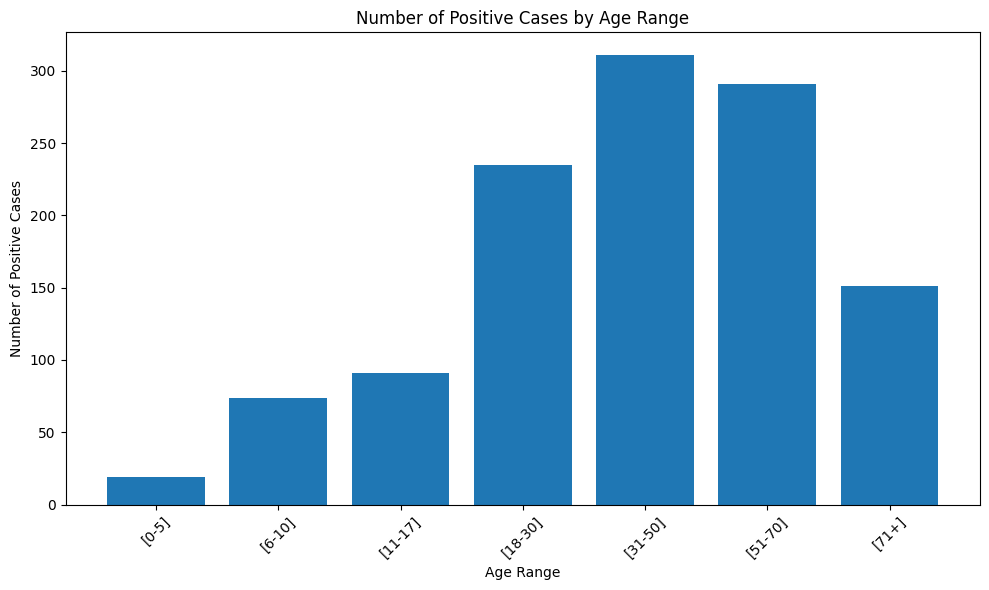

In [17]:
# Filter out valid ages and select necessary columns
age_df = df.select("demographics.age", "laboratory.covid19.result").filter(col("demographics.age").isNotNull())

# Create age_range and sort_key in one step
age_ranges_df = age_df.withColumn(
    "age_range",
    when((col("age") >= 0) & (col("age") <= 5), "[0-5]")
    .when((col("age") >= 6) & (col("age") <= 10), "[6-10]")
    .when((col("age") >= 11) & (col("age") <= 17), "[11-17]")
    .when((col("age") >= 18) & (col("age") <= 30), "[18-30]")
    .when((col("age") >= 31) & (col("age") <= 50), "[31-50]")
    .when((col("age") >= 51) & (col("age") <= 70), "[51-70]")
    .when((col("age") > 70), "[71+]")
    .otherwise("Unknown")
).withColumn(
    "sort_key",
    when((col("age") >= 0) & (col("age") <= 5), 1)
    .when((col("age") >= 6) & (col("age") <= 10), 2)
    .when((col("age") >= 11) & (col("age") <= 17), 3)
    .when((col("age") >= 18) & (col("age") <= 30), 4)
    .when((col("age") >= 31) & (col("age") <= 50), 5)
    .when((col("age") >= 51) & (col("age") <= 70), 6)
    .when((col("age") > 70), 7)
    .otherwise(8)
)

# Filter, group, and count positive cases
positive_cases_by_age = (
    age_ranges_df.filter(col("result") == "Detected (qualifier value)")
    .groupBy("age_range", "sort_key")
    .agg(count("*").alias("count"))
    .orderBy("sort_key")
)

# Convert to Pandas for plotting
positive_cases_by_age_pd = positive_cases_by_age.toPandas()

# Plot with Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(positive_cases_by_age_pd["age_range"], positive_cases_by_age_pd["count"])
plt.xlabel("Age Range")
plt.ylabel("Number of Positive Cases")
plt.title("Number of Positive Cases by Age Range")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Cumulative Covid Cases

24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 0

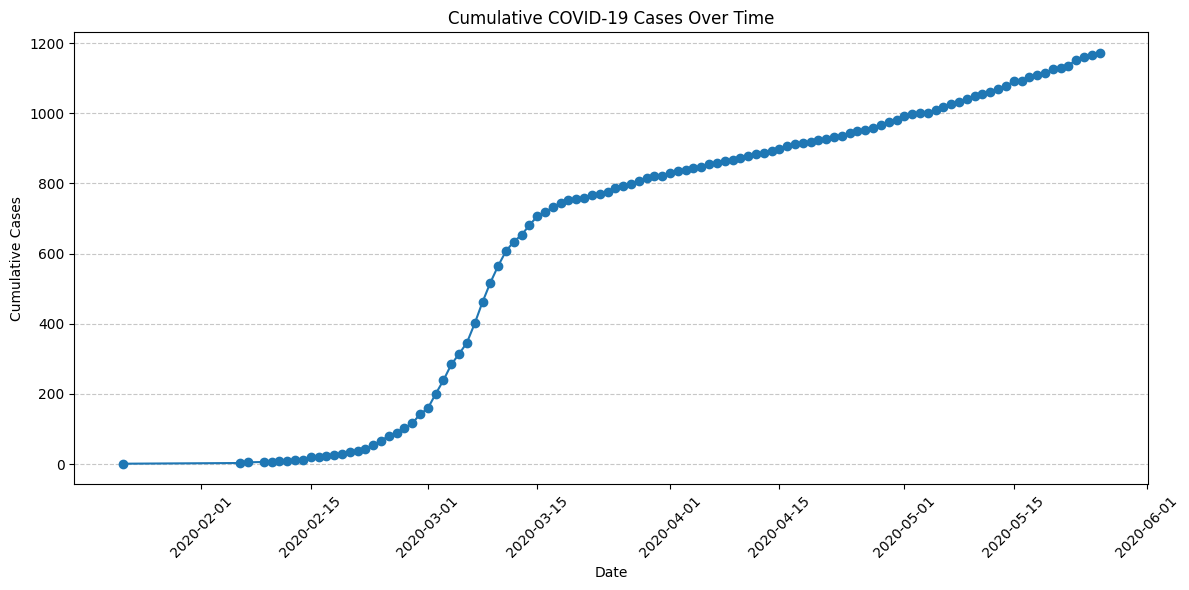

In [18]:
# Select date and covid result columns and filter only positive cases
cases_df = df.select("encounter.date", "laboratory.covid19.result") \
    .filter(col("laboratory.covid19.result") == "Detected (qualifier value)") \
    .withColumnRenamed("date", "case_date")

# Ensure case_date is treated as a date type
cases_df = cases_df.withColumn("case_date", col("case_date").cast("date"))

# Create a cumulative sum window
window_spec = Window.orderBy("case_date").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Calculate cumulative sum
cumulative_cases_df = cases_df.groupBy("case_date") \
    .count() \
    .orderBy("case_date") \
    .withColumn("cumulative_count", _sum("count").over(window_spec))

# Convert to Pandas for plotting
cumulative_cases_pd = cumulative_cases_df.toPandas()

# Plot cumulative cases over time
plt.figure(figsize=(12, 6))
plt.plot(cumulative_cases_pd["case_date"], cumulative_cases_pd["cumulative_count"], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Cumulative Cases")
plt.title("Cumulative COVID-19 Cases Over Time")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Top Medications Over Patients

24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 08:31:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/16 0

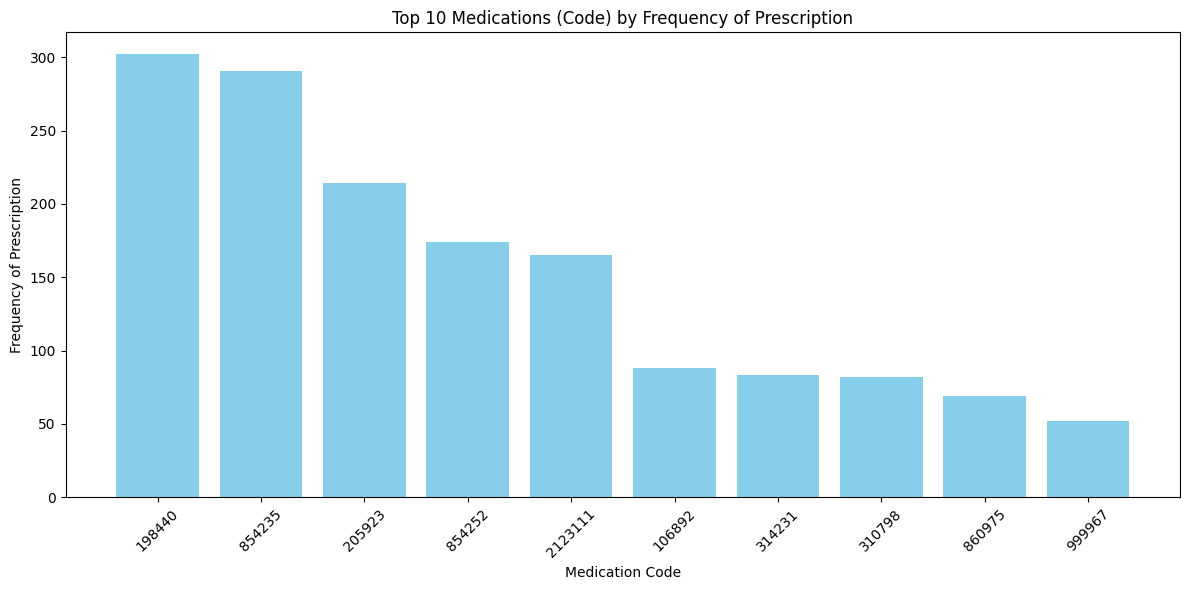

In [19]:
# Flatten the medications array
flattened_medications = df.select(explode(col("medications.code")).alias("medication_code"))

# Count frequency of each medication
medication_frequency = flattened_medications.groupBy("medication_code").agg(
    count("*").alias("frequency")
)

# Define a window for ranking
window_spec = Window.orderBy(col("frequency").desc())

# Add rank to the DataFrame
ranked_medications = medication_frequency.withColumn("rank", rank().over(window_spec))

# Convert to Pandas
ranked_medications_pd = ranked_medications.toPandas()

# Sort by rank to ensure the plot is ordered
ranked_medications_pd = ranked_medications_pd.sort_values(by="rank")

# Plot the top 10 medications
top_10 = ranked_medications_pd.head(10)  # Adjust number of medications to display

plt.figure(figsize=(12, 6))
plt.bar(top_10["medication_code"], top_10["frequency"], color="skyblue")

# Add labels and title
plt.xlabel("Medication Code")
plt.ylabel("Frequency of Prescription")
plt.title("Top 10 Medications (Code) by Frequency of Prescription")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


## Top Medications Per Age Group

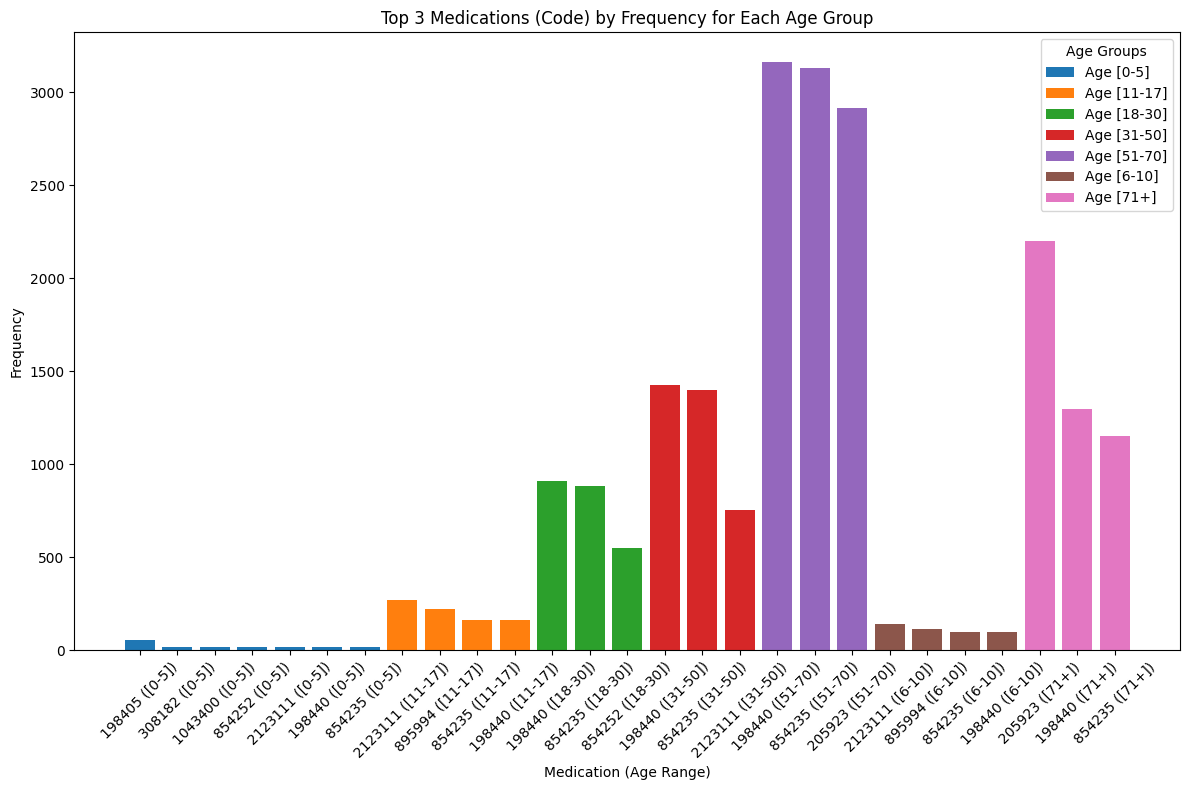

In [20]:
# Step 1: Flatten medications and join with age ranges
medications_df = df.select(
    col("demographics.age"), 
    explode(col("medications.code")).alias("medication_code")
).join(age_ranges_df, on="age")

# Step 2: Count frequency of medications within each age group
medication_frequency = medications_df.groupBy("age_range", "medication_code").agg(
    count("*").alias("frequency")
)

# Step 3: Rank medications within each age group
window_spec = Window.partitionBy("age_range").orderBy(col("frequency").desc())
ranked_medications = medication_frequency.withColumn("rank", rank().over(window_spec))

# Step 4: Filter top 3 medications per age group
top_3_medications = ranked_medications.filter(col("rank") <= 3)

# Convert to Pandas for visualization
top_3_pd = top_3_medications.toPandas()

# Step 5: Visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot top medications for each age group
for age_range in top_3_pd["age_range"].unique():
    subset = top_3_pd[top_3_pd["age_range"] == age_range]
    ax.bar(
        subset["medication_code"] + " (" + age_range + ")",
        subset["frequency"],
        label=f"Age {age_range}"
    )

# Add labels and legend
plt.xlabel("Medication (Age Range)")
plt.ylabel("Frequency")
plt.title("Top 3 Medications (Code) by Frequency for Each Age Group")
plt.xticks(rotation=45)
plt.legend(title="Age Groups")
plt.tight_layout()
plt.show()


## Top Co-Morbidities

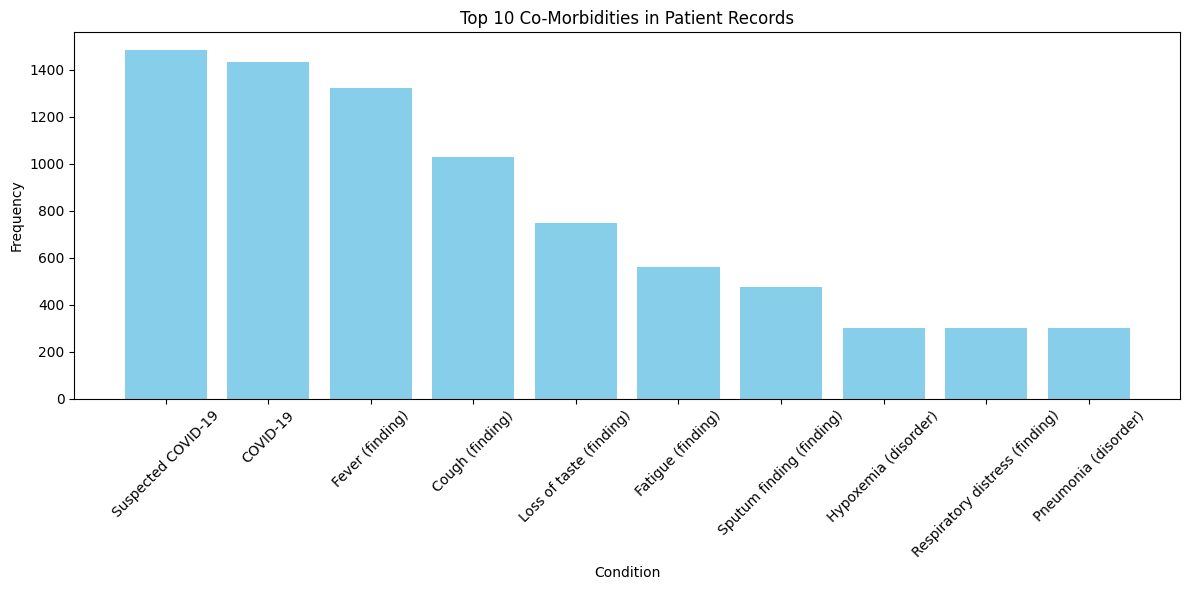

In [21]:
# Step 1: Flatten the conditions array
conditions_df = df.select(
    explode(col("conditions.description")).alias("condition_description")
)

# Step 2: Count the frequency of each co-morbidity
condition_frequency = conditions_df.groupBy("condition_description").agg(
    count("*").alias("frequency")
).orderBy(col("frequency").desc())

# Step 3: Convert to Pandas for visualization
condition_frequency_pd = condition_frequency.toPandas()

# Step 4: Plot the top 10 co-morbidities
top_10_conditions = condition_frequency_pd.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_conditions["condition_description"], top_10_conditions["frequency"], color="skyblue")

# Add labels and title
plt.xlabel("Condition")
plt.ylabel("Frequency")
plt.title("Top 10 Co-Morbidities in Patient Records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Individual Analysis

### Average Oxygen Saturation for Positive/Negative Test Result Per Age
There is a lot of emphasis by companies like Apple on how oxygen saturation relates to the Covid. The claim then would be that a positive Covid results should be associated with a lower oxygen saturation result. However, the results of this analysis, show that with the exception of the youngest age group, the average oxygen saturation levels for positive results is actually slightly higher than the negative results. There are myriad reasons this could be the case, the most obvious being the timing of the test (perhaps in the beginning stages of the disease, a person's blood saturation has not fallen yet), or a lack of adequate data to draw any conclusions. Of course, it should be noted that, even when there is a difference, it is not much and further analysis would need to be done to determine the statistical significance.

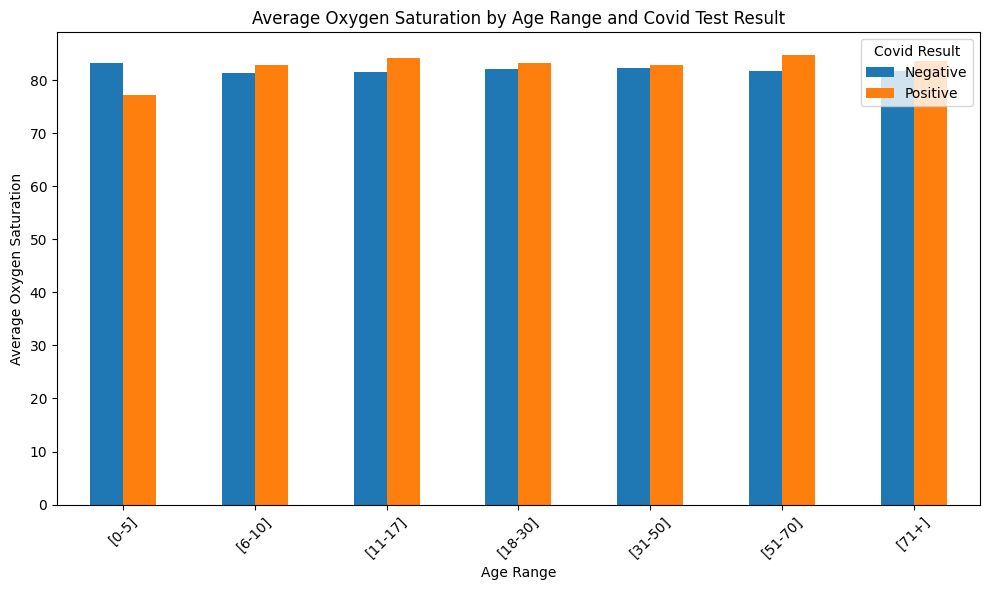

In [22]:
# Filter out valid ages and select necessary columns
oxygen_df = df.select(
    col("demographics.age").alias("age"),
    col("laboratory.covid19.result").alias("covid_result"),
    col("vitals.current.oxygen_saturation.value").alias("oxygen_saturation")
).filter(col("oxygen_saturation").isNotNull())

# Create age ranges with sorting keys
age_ranges_df = oxygen_df.withColumn(
    "age_range",
    when((col("age") >= 0) & (col("age") <= 5), "[0-5]")
    .when((col("age") >= 6) & (col("age") <= 10), "[6-10]")
    .when((col("age") >= 11) & (col("age") <= 17), "[11-17]")
    .when((col("age") >= 18) & (col("age") <= 30), "[18-30]")
    .when((col("age") >= 31) & (col("age") <= 50), "[31-50]")
    .when((col("age") >= 51) & (col("age") <= 70), "[51-70]")
    .when((col("age") > 70), "[71+]")
    .otherwise("Unknown")
).withColumn(
    "sort_key",
    when((col("age") >= 0) & (col("age") <= 5), 1)
    .when((col("age") >= 6) & (col("age") <= 10), 2)
    .when((col("age") >= 11) & (col("age") <= 17), 3)
    .when((col("age") >= 18) & (col("age") <= 30), 4)
    .when((col("age") >= 31) & (col("age") <= 50), 5)
    .when((col("age") >= 51) & (col("age") <= 70), 6)
    .when((col("age") > 70), 7)
    .otherwise(8)
)

# Group by age range and Covid test result, calculate average oxygen saturation
avg_oxygen_df = age_ranges_df.groupBy("age_range", "covid_result", "sort_key") \
    .agg(avg("oxygen_saturation").alias("avg_oxygen_saturation"))

# Order by sort_key
ordered_oxygen_df = avg_oxygen_df.orderBy("sort_key")

# Convert to Pandas DataFrame for visualization
pandas_df = ordered_oxygen_df.toPandas()

# Pivot the DataFrame for plotting
pivot_df = pandas_df.pivot(index="age_range", columns="covid_result", values="avg_oxygen_saturation")

# Reorder the index to ensure correct order of age ranges
age_range_order = ["[0-5]", "[6-10]", "[11-17]", "[18-30]", "[31-50]", "[51-70]", "[71+]"]
pivot_df = pivot_df.reindex(age_range_order)

# Plot the data
pivot_df.plot(kind="bar", figsize=(10, 6))
plt.title("Average Oxygen Saturation by Age Range and Covid Test Result")
plt.xlabel("Age Range")
plt.ylabel("Average Oxygen Saturation")
plt.xticks(rotation=45)
plt.legend(title="Covid Result", labels=["Negative", "Positive"])
plt.tight_layout()
plt.show()

### Temperature and HR vs Covid Result
During the height of the pandemic, it was a fact of life that a high body temperature was the leading way to screen for Covid, where anyone with a fever (38 degrees Celsius) was immediately isolated. I wanted to check to see if that held in the data (and also see if an elevated HR had any effect). While the visualization below shows for sure that a vast majority of those with an elevated temperature had a positive test result, there seems to be a threshold of 37.5 degrees Celsius, past which it is very likely the person tests positive for Covid. In fact, there is no positive result where the person had a body temperature below 37 degrees. However, what's more interesting is the gap in the data around that 37.5 degree threshold, where it does not seem as though many patients had a temperature near 37.5. My best guess is that this is some kind of rounding error when converting from Fahrenheit to Celsius, or that there is actually data missing. 

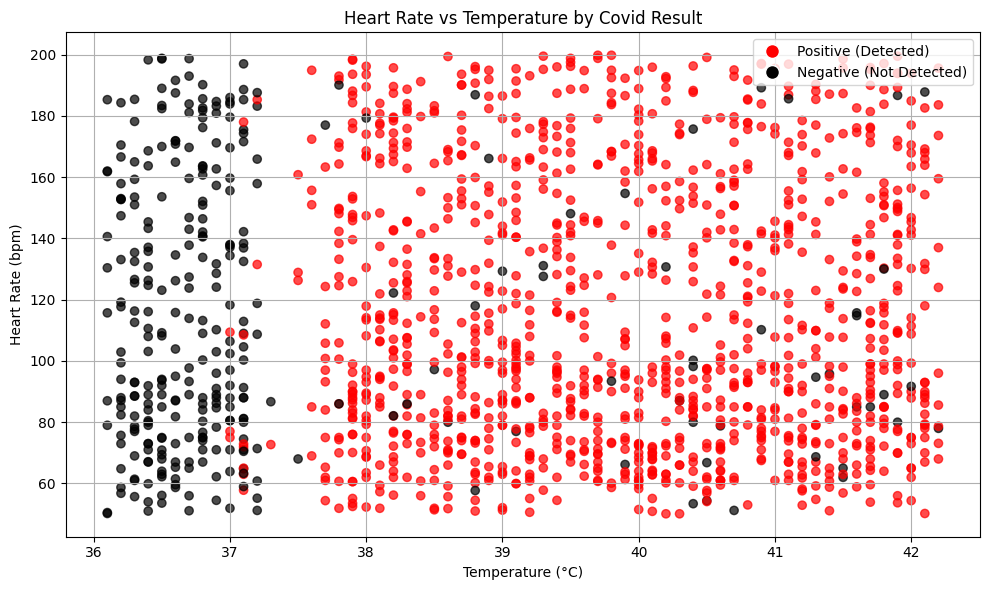

In [23]:
# Extract relevant vitals and laboratory data
health_df = df.select(
    col("vitals.current.heart_rate.value").alias("heart_rate"),
    col("vitals.current.temperature.value").alias("temperature"),
    col("laboratory.covid19.result").alias("covid_result")
).filter(
    col("heart_rate").isNotNull() &
    col("temperature").isNotNull()
)

# Convert to Pandas for plotting
pandas_health_df = health_df.select(
    col("temperature"),
    col("heart_rate"),
    col("covid_result")
).toPandas()

# Map Covid result to colors
pandas_health_df["color"] = pandas_health_df["covid_result"].map(
    {"Detected (qualifier value)": "red", "Not detected (qualifier value)": "black"}
)

# Filter rows to include only valid color mappings
pandas_health_df = pandas_health_df[pandas_health_df["color"].notnull()]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(
    pandas_health_df["temperature"],
    pandas_health_df["heart_rate"],
    c=pandas_health_df["color"],
    alpha=0.7
)
plt.title("Heart Rate vs Temperature by Covid Result")
plt.xlabel("Temperature (°C)")
plt.ylabel("Heart Rate (bpm)")
plt.legend([
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10)
], ['Positive (Detected)', 'Negative (Not Detected)'], loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

### Gender Disparity in Covid Cases

How do positive Covid-19 case counts compare between genders across different age ranges? This analysis is valuable because it identifies patterns of Covid-19 infection rates within demographic segments, specifically highlighting age and gender differences. Understanding these trends can help public health officials target interventions such as vaccination, testing, and education campaigns toward specific age groups or genders. For example, the results indicate that in the 51-70 age group, females show significantly higher positive case counts compared to males. Conversely, other age ranges show less discrepancy between genders.

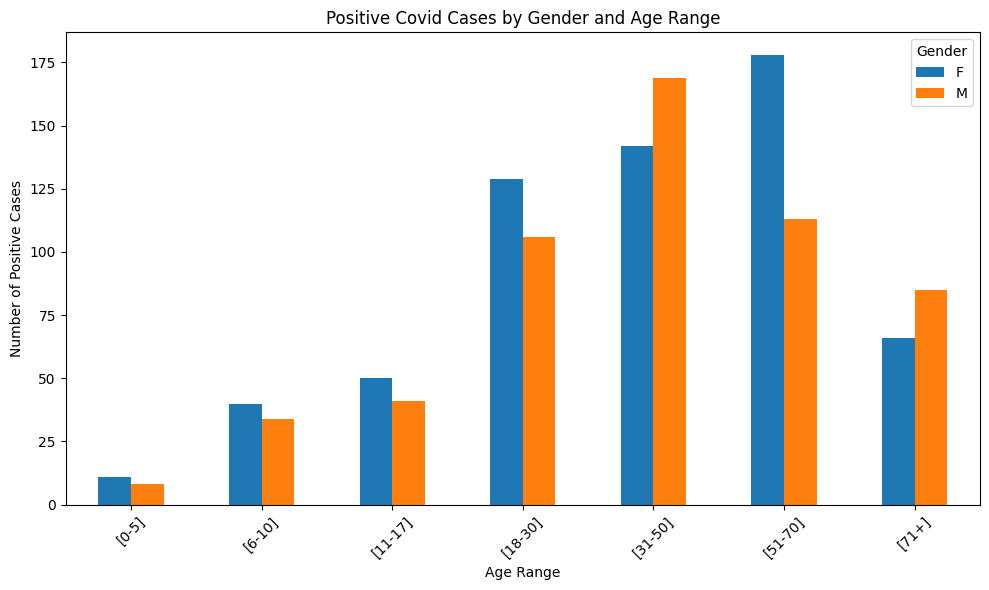

In [24]:
# Filter out valid ages and select necessary columns
gender_age_df = df.select(
    col("demographics.age").alias("age"),
    col("demographics.gender").alias("gender"),
    col("laboratory.covid19.result").alias("covid_result")
).filter(col("covid_result") == "Detected (qualifier value)")

# Create age ranges with sorting keys
age_ranges_df = gender_age_df.withColumn(
    "age_range",
    when((col("age") >= 0) & (col("age") <= 5), "[0-5]")
    .when((col("age") >= 6) & (col("age") <= 10), "[6-10]")
    .when((col("age") >= 11) & (col("age") <= 17), "[11-17]")
    .when((col("age") >= 18) & (col("age") <= 30), "[18-30]")
    .when((col("age") >= 31) & (col("age") <= 50), "[31-50]")
    .when((col("age") >= 51) & (col("age") <= 70), "[51-70]")
    .when((col("age") > 70), "[71+]")
    .otherwise("Unknown")
).withColumn(
    "sort_key",
    when((col("age") >= 0) & (col("age") <= 5), 1)
    .when((col("age") >= 6) & (col("age") <= 10), 2)
    .when((col("age") >= 11) & (col("age") <= 17), 3)
    .when((col("age") >= 18) & (col("age") <= 30), 4)
    .when((col("age") >= 31) & (col("age") <= 50), 5)
    .when((col("age") >= 51) & (col("age") <= 70), 6)
    .when((col("age") > 70), 7)
    .otherwise(8)
)

# Group by age range, gender, and sort_key, count positive cases
positive_cases_df = age_ranges_df.groupBy("age_range", "gender", "sort_key") \
    .agg(count("*").alias("positive_cases"))

# Order by sort_key
ordered_cases_df = positive_cases_df.orderBy("sort_key")

# Convert to Pandas DataFrame for visualization
pandas_cases_df = ordered_cases_df.toPandas()

# Pivot the DataFrame for plotting
pivot_df = pandas_cases_df.pivot(index="age_range", columns="gender", values="positive_cases")

# Reorder the index to ensure correct order of age ranges
age_range_order = ["[0-5]", "[6-10]", "[11-17]", "[18-30]", "[31-50]", "[51-70]", "[71+]"]
pivot_df = pivot_df.reindex(age_range_order)

# Plot the data
pivot_df.plot(kind="bar", figsize=(10, 6))
plt.title("Positive Covid Cases by Gender and Age Range")
plt.xlabel("Age Range")
plt.ylabel("Number of Positive Cases")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()